In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder, CountEncoder
from sklearn.preprocessing import StandardScaler

# Dataset

The dataset consists of 2 files: the `test` file and the `train` file. The `test` file is 674 MB, the `train` file is 6 GB. In order to load the data faster, we can choose two ways: pick only numerical columns or use the `pyarrow` engine. However, let's load all columns. As you can see down below, we can decrease the load time from ~52 seconds to mere ~19 seconds with using the `pyarrow` engine. That's **2.7** times speedup.

In [4]:
df = pd.read_csv("./dataset/train", engine="pyarrow")

# save df as parquet
df.to_parquet("./dataset/train.parquet", engine="pyarrow")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 7.2+ GB


#### Check for Missing Values

In [4]:
df.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

#### Find the Number of Unique Values in Object Type Columns

In [5]:
columns = ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']

for col in columns:
    print(f"{col}: {df[col].nunique()}")

site_id: 4737
site_domain: 7745
site_category: 26
app_id: 8552
app_domain: 559
app_category: 36
device_id: 2686408
device_ip: 6729486
device_model: 8251


#### Acquire the Numerical and Non-Numerical Columns

In [6]:
numerical_columns = df.select_dtypes(include=[np.int64, np.float64]).columns
numerical_columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21'],
      dtype='object')

In [7]:
non_numerical_columns = [col for col in df.columns if col not in numerical_columns]
non_numerical_columns

['site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model']

#### Convert `hour` Column to Meaningful Values

In [8]:
df['hour'] = pd.to_datetime(df['hour'], format='%y%m%d%H')

# Data Exploration

From the graph below, we can see the relationship between the number of clicks and hour. We can also notice it resembles Normal Distribution.
Clearly, Most ads are clicked in the morning and in the afternoon. From this we can tell, most people use their phones in the morning after waking up and in the afternoon while they are having lunch.

The conclusion is, a lot of ads getting clicked in the morning after users waking up around 8 or 9 AM and in the afternoon while they are having lunch / breaktime.

<Axes: xlabel='hour'>

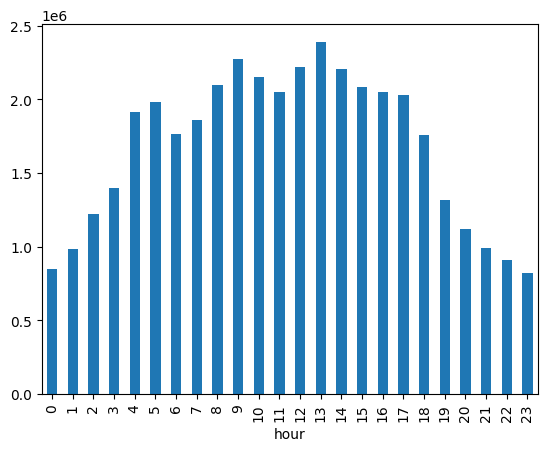

In [9]:
# visualize the relationship between click and hour
df['hour'].dt.hour
df['hour'].dt.dayofweek
df['hour'].dt.month
df['hour'].dt.year  

df['hour'].dt.hour.value_counts().sort_index().plot(kind='bar')

### Relationships between `clicks` and other features

In [10]:
def create_bar_plot(ax, data, title, xlabel, ylabel, top_n=None):
  if top_n:
      data = data[:top_n]  # Select only the top n values
  ax.bar(data.index, data.values)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

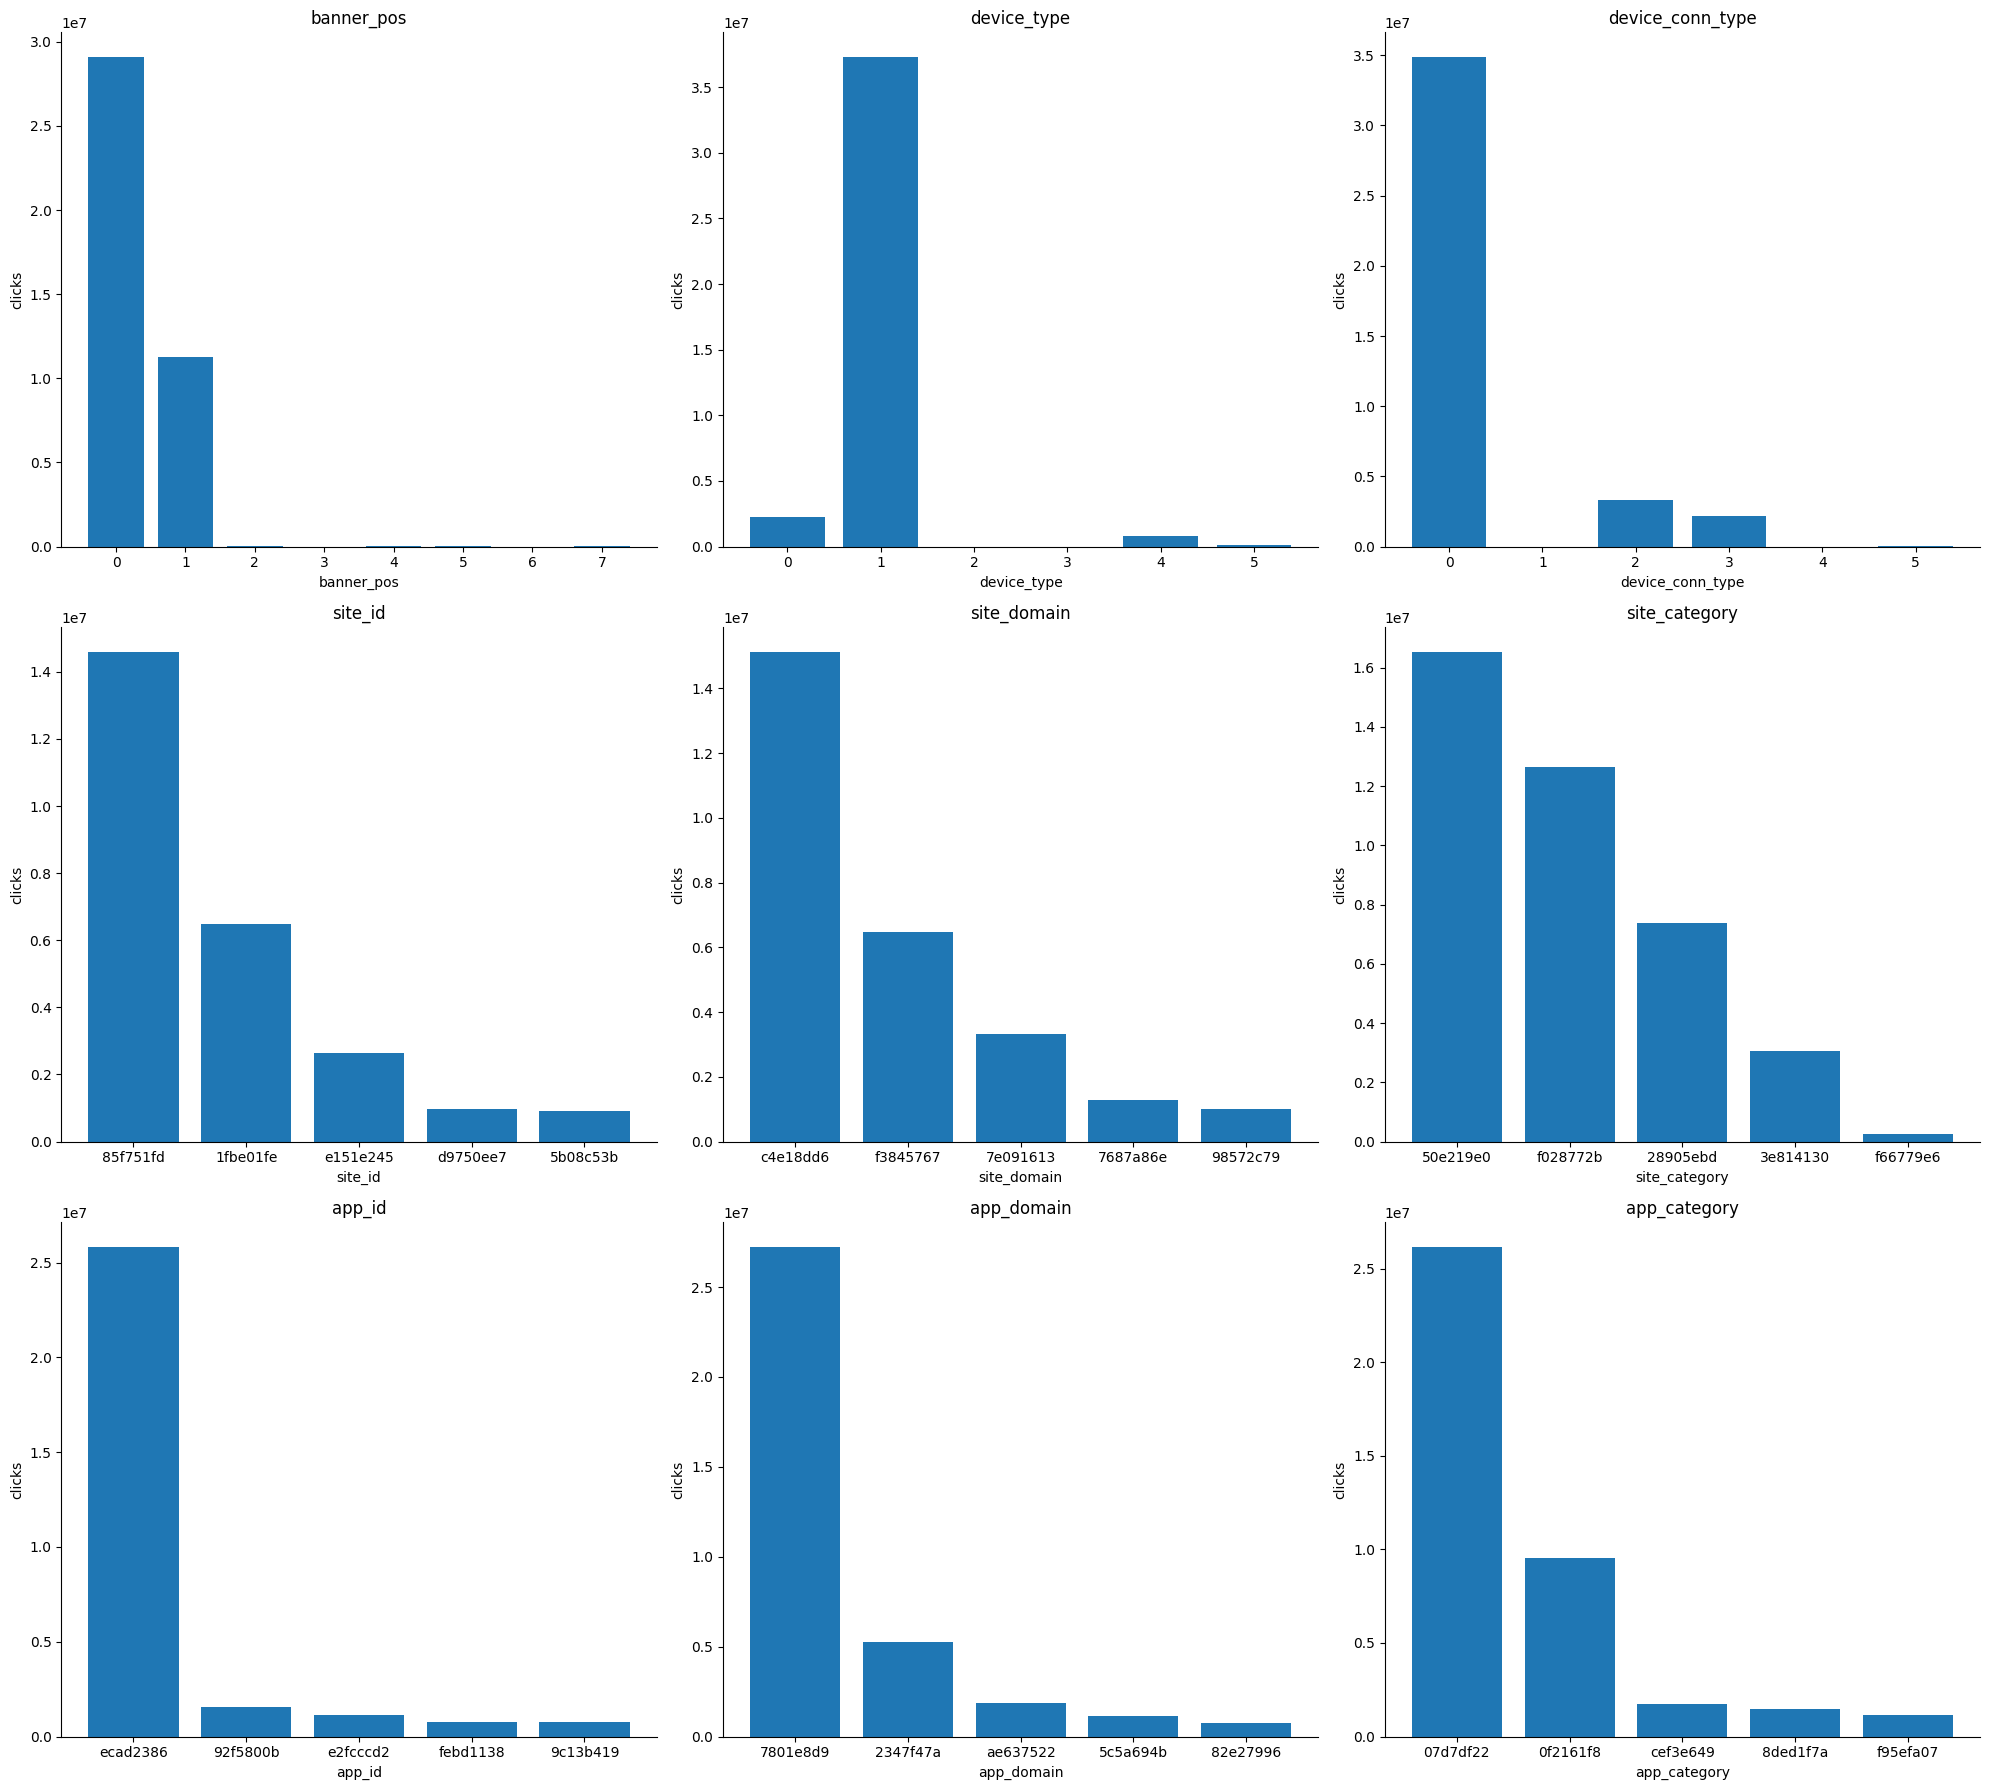

In [11]:
top_n_values = 5
columns_list = [
  ['banner_pos', 'device_type', 'device_conn_type'],
  ['site_id', 'site_domain', 'site_category'],
  ['app_id', 'app_domain', 'app_category']
]
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# Iterate through each group of columns and corresponding subplot rows
for i, columns in enumerate(columns_list):
  for j, column in enumerate(columns):
    if 'site' in column:
      create_bar_plot(
        axes[i, j], 
        df[column].value_counts(), 
        column, 
        column, 
        'clicks',
        top_n=top_n_values
      )
    elif 'app' in column:
      create_bar_plot(
        axes[i, j], 
        df[column].value_counts(), 
        column, 
        column, 
        'clicks',
        top_n=top_n_values
      )
    else:
      create_bar_plot(
        axes[i, j], 
        df[column].value_counts(), 
        column, 
        column, 
        'clicks'
      )

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


From the graph in the first row, there are some points can be taken:
1. ads are in the `0`th and `1`th positions are likely to be clicked
2. `device_type` 1 is the mostly used devices when users clicked their ads
3. `device_conn_type` 0 is the most common connection type when ads were clicked.
  
From the graph in the second row above, we can see that ads were likely to be clicked if:
1. site_id is `85f751fd` 
2. site_domain is `c4e18dd6`
3. site_category is `50e219e0`

From the graph in the third row above, we can see that ads were likely to be clicked if:
1. app_id is `ecad2386`
2. app_domain is `7801e8d9`
3. app_category is `07d7df22`